In [43]:
from keras.datasets import mnist
import numpy as np
from numpy import array
from math import log
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from itertools import product
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.feature_selection import *
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
import tensorflow as tf
import copy
from skimage.util import *

#load MNIST
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

In [2]:
def image_set_preprocessing(X, y, batch_ratio = 1, pad_size=2, pad_method='constant'):
    X_pad = np.pad(X, ((0,0),(pad_size,pad_size),(pad_size,pad_size)), 'constant')
    
    batch_size = (int)(X_pad.shape[0]*batch_ratio)
    
    #order = np.array(range(X_pad.shape[0]))
    #np.random.shuffle(order)
    #X_pad_shuffle = X_pad[order]
    #y_shuffle = y[order]
    X_pad_shuffle = X_pad
    y_shuffle = y

    X_train_batch = ((X_pad_shuffle[0:batch_size, :, :]).astype('float32'))/255
    y_train_batch = y_shuffle[0:batch_size,]
    X_train_batch = X_train_batch.reshape(X_train_batch.shape[0], X_train_batch.shape[1], X_train_batch.shape[2], 1)
    
    return X_train_batch, y_train_batch

def image_set_preprocessing_v2(X, y, batch_ratio = 1, pad_size=2, pad_method='constant'):
    X_pad = np.pad(X, ((0,0),(pad_size,pad_size),(pad_size,pad_size)), 'constant')
    
    batch_size = (int)(X_pad.shape[0]*batch_ratio)
    
    order = np.array(range(X_pad.shape[0]))
    np.random.shuffle(order)
    X_pad_shuffle = X_pad[order]
    y_shuffle = y[order]

    X_train_batch = ((X_pad_shuffle[0:batch_size, :, :]).astype('float32'))/255
    for i in range(X_train_batch.shape[0]):
        X_train_batch[i,:,:] = random_noise(X_train_batch[i,:,:], clip=True)
    y_train_batch = y_shuffle[0:batch_size,]
    X_train_batch = X_train_batch.reshape(X_train_batch.shape[0], X_train_batch.shape[1], X_train_batch.shape[2], 1)
    
    return X_train_batch, y_train_batch

def flatten_patches(cubio):
    window_shape = (1,2,2,cubio.shape[3])
    step = (1,2,2,cubio.shape[3])
    patches = view_as_windows(cubio, window_shape, step)
    patches = patches.squeeze(axis = (3,4))
    patches_panel = patches.reshape(-1, patches.shape[-3]*patches.shape[-2]*patches.shape[-1])
    
    return patches_panel

def remove_low_variance(patches_panel,thr=0.05):
    var = np.var(patches_panel, axis = 1)
    patches_clean = patches_panel[var>thr]
    
    return patches_clean

def remove_patches_mean(patches):
    mean = patches.mean(axis = 1)
    patches_mean_remov = (patches.T-mean).T
    
    return patches_mean_remov

def pca_kernel(patches, n_comps, kernel):
    pca = PCA(n_components = n_comps)
    pca.fit(patches)
    kernel.append(pca)  
    
def pca_kernel_v2(patches, kernel):
    pca = PCA()
    pca.fit(patches)
    kernel.append(pca)
    
def pca_kernel_v3(patches, n_comps, kernel):
    pca = KernelPCA(n_components = n_comps)
    pca.fit(patches)
    kernel.append(pca)
    
def pca_transform(kernel, layer, patches_mean_remov, patches_panel, X_train):
    n_sample = X_train.shape[0]
    h = (int)(X_train.shape[1]/pow(2,layer))
    patches_proj = k[layer-1].transform(patches_mean_remov)
    cubio_pos = patches_proj.reshape(n_sample,h,h,-1)
    cubio_neg = -cubio_pos
    cubio_pca = np.concatenate((cubio_pos, cubio_neg), axis=3)
    dc = patches_panel.mean(axis=1)*2
    dc = dc.reshape(n_sample, h, h, -1)
    cubio_next = np.concatenate((cubio_pca, dc), axis=3)
    
    return cubio_next

def pca_transform_v2(kernel, layer, patches_mean_remov, patches_panel, X_train):
    n_sample = X_train.shape[0]
    h = (int)(X_train.shape[1]/pow(2,layer))
    patches_proj = k[layer-1].transform(patches_mean_remov)
    cubio_pos = patches_proj.reshape(n_sample,h,h,-1)
    dc = patches_panel.mean(axis=1)*2
    dc = dc.reshape(n_sample, h, h, -1)
    cubio_next = np.concatenate((cubio_pos, dc), axis=3)
    
    return cubio_next

def relu(cubio):
    cubio_relu = cubio * (cubio > 0)
    
    return cubio_relu

def tanh(cubio):
    cubio_tanh = np.divide(np.exp(cubio), 1+np.exp(cubio))
    
    return cubio_tanh

def one_stage_training(cubio, layer, n_comps, kernel, feature_list, X):
    print("training at the %dth layer ..." %(layer))
    patches_panel = flatten_patches(cubio)
    patches_mean_remov = remove_patches_mean(patches_panel)
    if layer == 1:
        patches_clean = remove_low_variance(patches_mean_remov)
    else:
        patches_clean = patches_mean_remov
    pca_kernel(patches_clean,n_comps[layer-1], kernel)
    cubio_next = relu(pca_transform(kernel, layer, patches_mean_remov, patches_panel, X))
    feature_list.append(cubio_next)
    print("Done! the shape of output cubio is %s." %(cubio_next.shape,))
    
    return cubio_next

def one_stage_training_v2(cubio, layer, kernel, feature_list, X):
    print("training at the %dth layer ..." %(layer))
    patches_panel = flatten_patches(cubio)
    patches_mean_remov = remove_patches_mean(patches_panel)
    if layer == 1:
        patches_clean = remove_low_variance(patches_mean_remov)
    else:
        patches_clean = patches_mean_remov
    pca_kernel_v2(patches_clean,kernel)
    cubio_next = relu(pca_transform_v2(kernel, layer, patches_mean_remov, patches_panel, X))
    feature_list.append(cubio_next)
    print("Done! the shape of output cubio is %s." %(cubio_next.shape,))
    
    return cubio_next

def one_stage_training_v3(cubio, layer, kernel, feature_list, X):
    print("training at the %dth layer ..." %(layer))
    patches_panel = flatten_patches(cubio)
    patches_mean_remov = remove_patches_mean(patches_panel)
    if layer == 1:
        patches_clean = remove_low_variance(patches_mean_remov)
    else:
        patches_clean = patches_mean_remov
    pca_kernel(patches_clean,n_comps[layer-1],kernel)
    cubio_next = tanh(pca_transform_v2(kernel, layer, patches_mean_remov, patches_panel, X))
    feature_list.append(cubio_next)
    print("Done! the shape of output cubio is %s." %(cubio_next.shape,))
    
    return cubio_next

def feature_fusion(feature_list, num_layers):
    feature = feature_list[0].reshape(feature_list[0].shape[0], -1)
    for i in range(num_layers-1):
        feature = np.concatenate((feature,feature_list[i+1].reshape(feature_list[i+1].shape[0], -1)), axis=1)
    print("the shape of features we get is %s." %(feature.shape,))
    return feature

def Reduce_Feature(n_comps, feature):
    pca = PCA(n_components = n_comps)
    X_pc = pca.fit_transform(feature)
    print("the number of dimensions kept is %d." %(X_pc.shape[1]))
    
    return X_pc, pca

def Reduce_Feature_v2(n_comps, feature):
    pca = KernelPCA(n_components = n_comps)
    X_pc = pca.fit_transform(feature)
    print("the number of dimensions kept is %d." %(X_pc.shape[1]))
    
    return X_pc, pca

def F_test(percent, feature, label):
    Ftest = SelectPercentile(chi2, percent)
    X_f = Ftest.fit_transform(feature, label)
    print("the number of feature dimensions passing F-test is %d." %(X_f.shape[1]))

    return X_f, Ftest

def RandomForest_FeatureSelect(percent, feature, label):
    forest = RandomForestClassifier(random_state=0, )
    forest.fit(feature, label)
    index = np.argsort(forest.feature_importances_*100)
    num = (int)((float)(feature.shape[1]*percent)/100)
    X_rf = feature[:,index[0:num]]
    print("the number of feature dimensions passing Random-Forest feature selection is %d." %(X_rf.shape[1]))
    
    return X_rf, forest, index

def RandomForest_FeatureSelect_test(percent, feature, index):
    num = (int)((float)(feature.shape[1]*percent)/100)
    X_rf = feature[:,index[0:num]]
    print("the number of feature dimensions passing Random-Forest feature selection is %d." %(X_rf.shape[1]))
    
    return X_rf
    
def SVM_training(feature, label, n_comps, percent):
    print('SVM is under training...')
    X_f, Ftest = F_test(percent, feature, label)
    X_pc, pca = Reduce_Feature(n_comps, X_f)
    clf = SVC()
    clf.fit(X_pc, label)
    y_pred = clf.predict(X_pc)
    accuracy = accuracy_score(label, y_pred)
    print("SVM accuracy on training sample is %f" %(accuracy))
    
    return Ftest, pca, clf, accuracy

def SVM_training_v2(X_pc, label):
    print('SVM is under training...')
    clf = SVC()
    clf.fit(X_pc, label)
    y_pred = clf.predict(X_pc)
    accuracy = accuracy_score(label, y_pred)
    print("SVM accuracy on training sample is %f" %(accuracy))
    
    return clf, accuracy

def RF_training(feature, label, n_comps, percent):
    print('Random Forest is under training...')
    X_f, Ftest = F_test(percent, feature, label)
    X_pc, pca = Reduce_Feature(n_comps, X_f)
    clf = RandomForestClassifier()  
    clf.fit(X_pc, label)
    y_pred = clf.predict(X_pc)
    accuracy = accuracy_score(label, y_pred)
    print("RF accuracy on training sample is %f" %(accuracy))
    
    return Ftest, pca, clf, accuracy

def RF_training_v2(X_pc, label):
    print('Random Forest is under training...')
    clf = RandomForestClassifier()  
    clf.fit(X_pc, label)
    y_pred = clf.predict(X_pc)
    accuracy = accuracy_score(label, y_pred)
    print("RF accuracy on training sample is %f" %(accuracy))
    
    return clf, accuracy

def one_stage_testing(cubio, layer, kernel, feature_list, X):
    print("training at the %dth layer ..." %(layer))
    patches_panel = flatten_patches(cubio)
    patches_mean_remov = remove_patches_mean(patches_panel)
    cubio_next = relu(pca_transform(kernel, layer, patches_mean_remov, patches_panel, X))
    feature_list.append(cubio_next)
    print("Done! the shape of output cubio is %s." %(cubio_next.shape,))
    
    return cubio_next

def one_stage_testing_v2(cubio, layer, kernel, feature_list, X):
    print("training at the %dth layer ..." %(layer))
    patches_panel = flatten_patches(cubio)
    patches_mean_remov = remove_patches_mean(patches_panel)
    cubio_next = relu(pca_transform_v2(kernel, layer, patches_mean_remov, patches_panel, X))
    feature_list.append(cubio_next)
    print("Done! the shape of output cubio is %s." %(cubio_next.shape,))
    
    return cubio_next

def one_stage_testing_v3(cubio, layer, kernel, feature_list, X):
    print("training at the %dth layer ..." %(layer))
    patches_panel = flatten_patches(cubio)
    patches_mean_remov = remove_patches_mean(patches_panel)
    cubio_next = tanh(pca_transform_v2(kernel, layer, patches_mean_remov, patches_panel, X))
    feature_list.append(cubio_next)
    print("Done! the shape of output cubio is %s." %(cubio_next.shape,))
    
    return cubio_next

def RF_testing(feature, label, Ftest, pca, clf):
    print("Test smaples are under Random Forest's testing...")
    feature_test = Ftest.transform(feature)
    print("the number of feature dimensions passing F-test is %d." %(feature_test.shape[1]))
    feature_pca = pca.transform(feature_test)
    print("the number of dimensions kept is %d." %(feature_pca.shape[1]))
    y_pred = clf.predict(feature_pca)
    accuracy = accuracy_score(label, y_pred)     
    print("RF accuracy on test sample is %f" %(accuracy))
    
    return accuracy, y_pred
          
def SVM_testing(feature, label, Ftest, pca, clf):
    print("Test smaples are under SVM's testing...")
    feature_test = Ftest.transform(feature)
    print("the number of feature dimensions passing F-test is %d." %(feature_test.shape[1]))
    feature_pca = pca.transform(feature_test)
    print("the number of dimensions kept is %d." %(feature_pca.shape[1]))
    y_pred = clf.predict(feature_pca)
    accuracy = accuracy_score(label, y_pred)     
    print("SVM accuracy on test sample is %f" %(accuracy))
    
    return accuracy, y_pred

# Augmented, ncomps controlled

In [3]:
#prepare training parameters list
k = []
feature_list = []
n_comps = [3, 4, 7, 6, 8]

#preprocess input image batch and label batch
X_train, y_train_batch = image_set_preprocessing(X_train_raw, y_train_raw, batch_ratio = 1)
cubio = copy.deepcopy(X_train)

#compute the number of layers
layer_cnt = (int)(log(X_train.shape[1])/log(2))

#forward training process
for layer in range(layer_cnt):
    cubio = one_stage_training(cubio, layer+1, n_comps, k, feature_list, X_train)

training at the 1th layer ...
Done! the shape of output cubio is (60000, 16, 16, 7).
training at the 2th layer ...
Done! the shape of output cubio is (60000, 8, 8, 9).
training at the 3th layer ...
Done! the shape of output cubio is (60000, 4, 4, 15).
training at the 4th layer ...
Done! the shape of output cubio is (60000, 2, 2, 13).
training at the 5th layer ...
Done! the shape of output cubio is (60000, 1, 1, 17).


In [5]:
#colloect all the features from all layers
features = feature_fusion(feature_list, layer_cnt)

#feature selection
X_f, Ftest = F_test(50, features, y_train_batch)

#feature reduction
X_pc_32, pca_32 = Reduce_Feature(32, X_f)
X_pc_64, pca_64 = Reduce_Feature(64, X_f)
X_pc_128, pca_128 = Reduce_Feature(128, X_f)

#SVM training
svm_32, accuracy_svm_training_32= SVM_training_v2(X_pc_32, y_train_batch)
svm_64, accuracy_svm_training_64= SVM_training_v2(X_pc_64, y_train_batch)
svm_128, accuracy_svm_training_128= SVM_training_v2(X_pc_128, y_train_batch)

the shape of features we get is (60000, 2677).
the number of feature dimensions passing F-test is 1338.
the number of dimensions kept is 32.
the number of dimensions kept is 64.
the number of dimensions kept is 128.
SVM is under training...
SVM accuracy on training sample is 0.995583
SVM is under training...
SVM accuracy on training sample is 0.993933
SVM is under training...
SVM accuracy on training sample is 0.989367


In [7]:
#Random Forest training
rf_32, accuracy_rf_training_32 = RF_training_v2(X_pc_32, y_train_batch)
rf_64, accuracy_rf_training_64 = RF_training_v2(X_pc_64, y_train_batch)
rf_128, accuracy_rf_training_128 = RF_training_v2(X_pc_128, y_train_batch)

Random Forest is under training...
RF accuracy on training sample is 0.998667
Random Forest is under training...
RF accuracy on training sample is 0.999033
Random Forest is under training...
RF accuracy on training sample is 0.998850


In [9]:
#preprocess testing image batch and label batch 
X_test, y_test_batch = image_set_preprocessing(X_test_raw, y_test_raw, batch_ratio = 1)

#prepare testing parameters list
feature_list_test = []

#forward testing process
cubio_test = copy.deepcopy(X_test)
for layer in range(layer_cnt):
    cubio_test = one_stage_testing(cubio_test, layer+1, k, feature_list_test, X_test)

#colloect all the features from all layers
features_test = feature_fusion(feature_list_test, layer_cnt)

#F-test --> PCA reducing dims --> SVM testing
accuracy_svm_testing_32, y_pred_svm_32 = SVM_testing(features_test, y_test_batch, Ftest, pca_32, svm_32)
accuracy_svm_testing_64, y_pred_svm_64 = SVM_testing(features_test, y_test_batch, Ftest, pca_64, svm_64)
accuracy_svm_testing_128, y_pred_svm_128 = SVM_testing(features_test, y_test_batch, Ftest, pca_128, svm_128)

#F-test --> PCA reducing dims --> RF testing
accuracy_rf_testing_32, y_pred_rf_32 = RF_testing(features_test, y_test_batch, Ftest, pca_32, rf_32)
accuracy_rf_testing_64, y_pred_rf_64 = RF_testing(features_test, y_test_batch, Ftest, pca_64, rf_64)
accuracy_rf_testing_128, y_pred_rf_128 = RF_testing(features_test, y_test_batch, Ftest, pca_128, rf_128)

training at the 1th layer ...
Done! the shape of output cubio is (10000, 16, 16, 7).
training at the 2th layer ...
Done! the shape of output cubio is (10000, 8, 8, 9).
training at the 3th layer ...
Done! the shape of output cubio is (10000, 4, 4, 15).
training at the 4th layer ...
Done! the shape of output cubio is (10000, 2, 2, 13).
training at the 5th layer ...
Done! the shape of output cubio is (10000, 1, 1, 17).
the shape of features we get is (10000, 2677).
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 1338.
the number of dimensions kept is 32.
SVM accuracy on test sample is 0.981400
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 1338.
the number of dimensions kept is 64.
SVM accuracy on test sample is 0.983500
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 1338.
the number of dimensions kept is 128.
SVM accuracy on test sample is 0.981200
Test smapl

In [17]:
#preprocess testing image batch and label batch 
X_test, y_test_batch = image_set_preprocessing(X_test_raw, y_test_raw, batch_ratio = 1)

#prepare testing parameters list
feature_list_test = []

#forward testing process
cubio_test = copy.deepcopy(X_test)
for layer in range(layer_cnt):
    cubio_test = one_stage_testing(cubio_test, layer+1, k, feature_list_test, X_test)

#colloect all the features from all layers
features_test = feature_fusion(feature_list_test, layer_cnt)

#F-test --> PCA reducing dims --> SVM testing
accuracy_svm_testing_64, y_pred_svm_64 = SVM_testing(features_test, y_test_batch, Ftest, pca_64, svm_64)

print(y_pred_svm_64)
print(y_test_batch)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_batch, y_pred_svm_64, labels = [0,1,2,3,4,5,6,7,8,9])

from sklearn.metrics import classification_report
rp = classification_report(y_test_batch, y_pred_svm_64, digits = 4)

print(cm)
print(rp)

training at the 1th layer ...
Done! the shape of output cubio is (10000, 16, 16, 7).
training at the 2th layer ...
Done! the shape of output cubio is (10000, 8, 8, 9).
training at the 3th layer ...
Done! the shape of output cubio is (10000, 4, 4, 15).
training at the 4th layer ...
Done! the shape of output cubio is (10000, 2, 2, 13).
training at the 5th layer ...
Done! the shape of output cubio is (10000, 1, 1, 17).
the shape of features we get is (10000, 2677).
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 1338.
the number of dimensions kept is 64.
SVM accuracy on test sample is 0.983500
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
[[ 973    0    1    0    0    2    1    1    2    0]
 [   0 1129    3    0    0    1    0    0    1    1]
 [   5    0 1013    1    1    0    1    7    4    0]
 [   0    0    2  996    1    3    0    4    3    1]
 [   0    0    3    0  963    0    4    0    1   11]
 [   2    0    0    8    1  873    2    1    3    2]
 [   

In [32]:
index = np.array([ 321,  447,  659,  740,  882,  947, 1014, 1112, 1232, 1242, 1247,
       1527, 1709, 1790, 1878, 1901, 2018, 2129, 2130, 2135, 2182, 2266,
       2293, 2597, 2654, 2896, 2939, 3073, 3225, 3422, 3534, 3558, 3727,
       3941, 4176, 4201, 4284, 4443, 4507, 4571, 4699, 4740, 4761, 4783,
       4860, 4879, 5937, 5955, 6576, 6597, 6625, 6651, 7216, 8246, 8527,
       9642, 9664, 9692, 9729])
y_diff = y_pred_svm_64-y_test_batch
index_2 = y_diff.nonzero()

In [55]:
index_2

(array([ 151,  247,  321,  340,  381,  445,  447,  448,  449,  495,  582,
         659,  689,  691,  707,  740,  882,  947,  951,  956,  965, 1014,
        1039, 1044, 1112, 1192, 1226, 1232, 1242, 1247, 1260, 1299, 1319,
        1328, 1393, 1494, 1500, 1522, 1530, 1549, 1553, 1581, 1609, 1681,
        1709, 1790, 1901, 2024, 2044, 2070, 2098, 2109, 2118, 2130, 2135,
        2182, 2185, 2189, 2224, 2272, 2293, 2299, 2371, 2387, 2406, 2414,
        2422, 2462, 2488, 2597, 2607, 2648, 2654, 2771, 2810, 2863, 2896,
        2927, 2939, 2953, 3060, 3073, 3117, 3405, 3422, 3475, 3503, 3520,
        3558, 3559, 3597, 3751, 3767, 3776, 3780, 3796, 3808, 3811, 3853,
        3902, 3941, 3985, 4065, 4075, 4078, 4163, 4176, 4201, 4224, 4248,
        4271, 4289, 4306, 4497, 4500, 4575, 4740, 4807, 4823, 4879, 4880,
        4966, 5457, 5642, 5734, 5936, 5937, 5955, 5973, 5985, 5997, 6035,
        6059, 6166, 6555, 6560, 6571, 6576, 6597, 6598, 6625, 6651, 6755,
        7434, 8094, 8325, 8339, 8527, 

In [63]:
#print(len(np.setdiff1d(index, index_2)))
#print(len(np.setdiff1d(index_2, index)))
#print(len(index))
index_2 = np.array(index_2)
index_2.shape

(1, 165)

# without augmented, without comps controlled

In [732]:
#prepare training parameters list
k = []
feature_list = []

#preprocess input image batch and label batch
X_train, y_train_batch = image_set_preprocessing(X_train_raw, y_train_raw, batch_ratio = 1)
cubio = copy.deepcopy(X_train)

#compute the number of layers
layer_cnt = (int)(log(X_train.shape[1])/log(2))

#forward training process
for layer in range(layer_cnt):
    cubio = one_stage_training_v2(cubio, layer+1, k, feature_list, X_train)

training at the 1th layer ...
Done! the shape of output cubio is (60000, 16, 16, 5).
training at the 2th layer ...
Done! the shape of output cubio is (60000, 8, 8, 21).
training at the 3th layer ...
Done! the shape of output cubio is (60000, 4, 4, 85).
training at the 4th layer ...
Done! the shape of output cubio is (60000, 2, 2, 341).
training at the 5th layer ...
Done! the shape of output cubio is (60000, 1, 1, 1365).


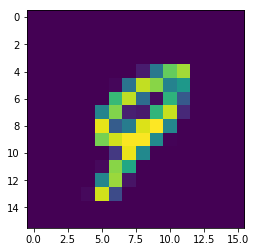

In [738]:
plt.imshow(feature_list[0][0,:,:,4])

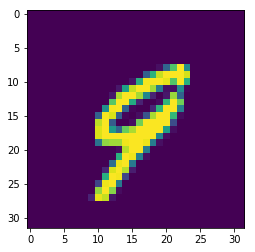

In [736]:
plt.imshow(X_train[0,:,:,0])

In [740]:
features.shape

(60000, 2677)

## only use the final layer output features

In [741]:
features = cubio.squeeze()
#F-test --> PCA reducing dims --> SVM training
Ftest, pca_32, svm_32, accuracy_svm_training_32= SVM_training(features, y_train_batch, 32, 50)
Ftest, pca_64, svm_64, accuracy_svm_training_64= SVM_training(features, y_train_batch, 64, 50)
Ftest, pca_128, svm_128, accuracy_svm_training_128= SVM_training(features, y_train_batch, 128, 50)

#F-test --> PCA reducing dims --> RF training
Ftest, pca_32, rf_32, accuracy_rf_training_32 = RF_training(features, y_train_batch, 32, 50)
Ftest, pca_64, rf_64, accuracy_rf_training_64 = RF_training(features, y_train_batch, 64, 50)
Ftest, pca_128, rf_128, accuracy_rf_training_128 = RF_training(features, y_train_batch, 128, 50)

SVM is under training...
the number of feature dimensions passing F-test is 682.
the number of dimensions kept is 32.
SVM accuracy on training sample is 0.787700
SVM is under training...
the number of feature dimensions passing F-test is 682.
the number of dimensions kept is 64.
SVM accuracy on training sample is 0.821700
SVM is under training...
the number of feature dimensions passing F-test is 682.
the number of dimensions kept is 128.
SVM accuracy on training sample is 0.818467
Random Forest is under training...
the number of feature dimensions passing F-test is 682.
the number of dimensions kept is 32.
RF accuracy on training sample is 0.996767
Random Forest is under training...
the number of feature dimensions passing F-test is 682.
the number of dimensions kept is 64.
RF accuracy on training sample is 0.997283
Random Forest is under training...
the number of feature dimensions passing F-test is 682.
the number of dimensions kept is 128.
RF accuracy on training sample is 0.997667

In [747]:
#preprocess testing image batch and label batch 
X_test, y_test_batch = image_set_preprocessing(X_test_raw, y_test_raw, batch_ratio = 1)

#prepare testing parameters list
feature_list_test = []

#forward testing process
cubio_test = copy.deepcopy(X_test)
for layer in range(layer_cnt):
    cubio_test = one_stage_testing_v2(cubio_test, layer+1, k, feature_list_test, X_test)

features_test = cubio_test.squeeze()

#F-test --> PCA reducing dims --> SVM testing
accuracy_svm_testing_32= SVM_testing(features_test, y_test_batch, Ftest, pca_32, svm_32)
accuracy_svm_testing_64= SVM_testing(features_test, y_test_batch, Ftest, pca_64, svm_64)
accuracy_svm_testing_128= SVM_testing(features_test, y_test_batch, Ftest, pca_128, svm_128)

#F-test --> PCA reducing dims --> RF testing
accuracy_rf_testing_32 = RF_testing(features_test, y_test_batch, Ftest, pca_32, rf_32)
accuracy_rf_testing_64 = RF_testing(features_test, y_test_batch, Ftest, pca_64, rf_64)
accuracy_rf_testing_128 = RF_testing(features_test, y_test_batch, Ftest, pca_128, rf_128)

training at the 1th layer ...
Done! the shape of output cubio is (10000, 16, 16, 5).
training at the 2th layer ...
Done! the shape of output cubio is (10000, 8, 8, 21).
training at the 3th layer ...
Done! the shape of output cubio is (10000, 4, 4, 85).
training at the 4th layer ...
Done! the shape of output cubio is (10000, 2, 2, 341).
training at the 5th layer ...
Done! the shape of output cubio is (10000, 1, 1, 1365).
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 682.
the number of dimensions kept is 32.
SVM accuracy on test sample is 0.790900
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 682.
the number of dimensions kept is 64.
SVM accuracy on test sample is 0.815500
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 682.
the number of dimensions kept is 128.
SVM accuracy on test sample is 0.816800
Test smaples are under Random Forest's testing...
the nu

## using features from all the layers

In [748]:
#colloect all the features from all layers
features = feature_fusion(feature_list, layer_cnt)

#F-test --> PCA reducing dims --> SVM training
Ftest, pca_32, svm_32, accuracy_svm_training_32= SVM_training(features, y_train_batch, 32, 50)
Ftest, pca_64, svm_64, accuracy_svm_training_64= SVM_training(features, y_train_batch, 64, 50)
Ftest, pca_128, svm_128, accuracy_svm_training_128= SVM_training(features, y_train_batch, 128, 50)

#F-test --> PCA reducing dims --> RF training
Ftest, pca_32, rf_32, accuracy_rf_training_32 = RF_training(features, y_train_batch, 32, 50)
Ftest, pca_64, rf_64, accuracy_rf_training_64 = RF_training(features, y_train_batch, 64, 50)
Ftest, pca_128, rf_128, accuracy_rf_training_128 = RF_training(features, y_train_batch, 128, 50)

the shape of features we get is (60000, 6713).
SVM is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 32.
SVM accuracy on training sample is 0.994133
SVM is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 64.
SVM accuracy on training sample is 0.991683
SVM is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 128.
SVM accuracy on training sample is 0.986333
Random Forest is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 32.
RF accuracy on training sample is 0.998767
Random Forest is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 64.
RF accuracy on training sample is 0.999017
Random Forest is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions ke

In [749]:
#colloect all the features from all layers
features_test = feature_fusion(feature_list_test, layer_cnt)

#F-test --> PCA reducing dims --> SVM testing
accuracy_svm_testing_32= SVM_testing(features_test, y_test_batch, Ftest, pca_32, svm_32)
accuracy_svm_testing_64= SVM_testing(features_test, y_test_batch, Ftest, pca_64, svm_64)
accuracy_svm_testing_128= SVM_testing(features_test, y_test_batch, Ftest, pca_128, svm_128)

#F-test --> PCA reducing dims --> RF testing
accuracy_rf_testing_32 = RF_testing(features_test, y_test_batch, Ftest, pca_32, rf_32)
accuracy_rf_testing_64 = RF_testing(features_test, y_test_batch, Ftest, pca_64, rf_64)
accuracy_rf_testing_128 = RF_testing(features_test, y_test_batch, Ftest, pca_128, rf_128)

the shape of features we get is (10000, 6713).
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 32.
SVM accuracy on test sample is 0.981500
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 64.
SVM accuracy on test sample is 0.981200
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 128.
SVM accuracy on test sample is 0.978700
Test smaples are under Random Forest's testing...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 32.
RF accuracy on test sample is 0.925500
Test smaples are under Random Forest's testing...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 64.
RF accuracy on test sample is 0.922500
Test smaples are under Random Forest's testing...
the number of 

# Add Noise to training images, without augments

In [767]:
#prepare training parameters list
k = []
feature_list = []
n_comps = [3, 4, 7, 6, 8]

#preprocess input image batch and label batch
X_train, y_train_batch = image_set_preprocessing_v2(X_train_raw, y_train_raw, batch_ratio = 1)
cubio = copy.deepcopy(X_train)

#compute the number of layers
layer_cnt = (int)(log(X_train.shape[1])/log(2))

#forward training process
for layer in range(layer_cnt):
    cubio = one_stage_training_v2(cubio, layer+1, k, feature_list, X_train)

training at the 1th layer ...
Done! the shape of output cubio is (60000, 16, 16, 5).
training at the 2th layer ...
Done! the shape of output cubio is (60000, 8, 8, 21).
training at the 3th layer ...
Done! the shape of output cubio is (60000, 4, 4, 85).
training at the 4th layer ...
Done! the shape of output cubio is (60000, 2, 2, 341).
training at the 5th layer ...
Done! the shape of output cubio is (60000, 1, 1, 1365).


In [768]:
#colloect all the features from all layers
features = feature_fusion(feature_list, layer_cnt)

#F-test --> PCA reducing dims --> SVM training
Ftest, pca_32, svm_32, accuracy_svm_training_32= SVM_training(features, y_train_batch, 32, 50)
Ftest, pca_64, svm_64, accuracy_svm_training_64= SVM_training(features, y_train_batch, 64, 50)
Ftest, pca_128, svm_128, accuracy_svm_training_128= SVM_training(features, y_train_batch, 128, 50)

#F-test --> PCA reducing dims --> RF training
Ftest, pca_32, rf_32, accuracy_rf_training_32 = RF_training(features, y_train_batch, 32, 50)
Ftest, pca_64, rf_64, accuracy_rf_training_64 = RF_training(features, y_train_batch, 64, 50)
Ftest, pca_128, rf_128, accuracy_rf_training_128 = RF_training(features, y_train_batch, 128, 50)

the shape of features we get is (60000, 6713).
SVM is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 32.
SVM accuracy on training sample is 0.992817
SVM is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 64.
SVM accuracy on training sample is 0.990100
SVM is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 128.
SVM accuracy on training sample is 0.983633
Random Forest is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 32.
RF accuracy on training sample is 0.998883
Random Forest is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 64.
RF accuracy on training sample is 0.998817
Random Forest is under training...
the number of feature dimensions passing F-test is 3356.
the number of dimensions ke

In [771]:
#preprocess testing image batch and label batch 
X_test, y_test_batch = image_set_preprocessing(X_test_raw, y_test_raw, batch_ratio = 1)

#prepare testing parameters list
feature_list_test = []

#forward testing process
cubio_test = copy.deepcopy(X_test)
for layer in range(layer_cnt):
    cubio_test = one_stage_testing_v2(cubio_test, layer+1, k, feature_list_test, X_test)

#colloect all the features from all layers
features_test = feature_fusion(feature_list_test, layer_cnt)

#F-test --> PCA reducing dims --> SVM testing
accuracy_svm_testing_32= SVM_testing(features_test, y_test_batch, Ftest, pca_32, svm_32)
accuracy_svm_testing_64= SVM_testing(features_test, y_test_batch, Ftest, pca_64, svm_64)
accuracy_svm_testing_128= SVM_testing(features_test, y_test_batch, Ftest, pca_128, svm_128)

#F-test --> PCA reducing dims --> RF testing
accuracy_rf_testing_32 = RF_testing(features_test, y_test_batch, Ftest, pca_32, rf_32)
accuracy_rf_testing_64 = RF_testing(features_test, y_test_batch, Ftest, pca_64, rf_64)
accuracy_rf_testing_128 = RF_testing(features_test, y_test_batch, Ftest, pca_128, rf_128)

training at the 1th layer ...
Done! the shape of output cubio is (10000, 16, 16, 5).
training at the 2th layer ...
Done! the shape of output cubio is (10000, 8, 8, 21).
training at the 3th layer ...
Done! the shape of output cubio is (10000, 4, 4, 85).
training at the 4th layer ...
Done! the shape of output cubio is (10000, 2, 2, 341).
training at the 5th layer ...
Done! the shape of output cubio is (10000, 1, 1, 1365).
the shape of features we get is (10000, 6713).
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 32.
SVM accuracy on test sample is 0.980100
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 64.
SVM accuracy on test sample is 0.980200
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 3356.
the number of dimensions kept is 128.
SVM accuracy on test sample is 0.975600
Test s

# Using Sigmoid as the activation function

In [6]:
#prepare training parameters list
k = []
feature_list = []
n_comps = [3, 4, 7, 6, 8]

#preprocess input image batch and label batch
X_train, y_train_batch = image_set_preprocessing_v2(X_train_raw, y_train_raw, batch_ratio = 1)
cubio = copy.deepcopy(X_train)

#compute the number of layers
layer_cnt = (int)(log(X_train.shape[1])/log(2))

#forward training process
for layer in range(layer_cnt):
    cubio = one_stage_training_v3(cubio, layer+1, k, feature_list, X_train)

training at the 1th layer ...
Done! the shape of output cubio is (60000, 16, 16, 4).
training at the 2th layer ...
Done! the shape of output cubio is (60000, 8, 8, 5).
training at the 3th layer ...
Done! the shape of output cubio is (60000, 4, 4, 8).
training at the 4th layer ...
Done! the shape of output cubio is (60000, 2, 2, 7).
training at the 5th layer ...
Done! the shape of output cubio is (60000, 1, 1, 9).


In [9]:
#colloect all the features from all layers
features = feature_fusion(feature_list, layer_cnt)

the shape of features we get is (60000, 1509).


In [17]:
X_f, Ftest = F_test(50, features, y_train_batch)
X_pc_32, pca_32 = Reduce_Feature(32, X_f)
X_pc_64, pca_64 = Reduce_Feature(64, X_f)
X_pc_128, pca_128 = Reduce_Feature(128, X_f)

the number of feature dimensions passing F-test is 754.
the number of dimensions kept is 32.
the number of dimensions kept is 64.
the number of dimensions kept is 128.


In [18]:
#F-test --> PCA reducing dims --> SVM training
svm_32, accuracy_svm_training_32= SVM_training_v2(X_pc_32, y_train_batch)
svm_64, accuracy_svm_training_64= SVM_training_v2(X_pc_64, y_train_batch)
svm_128, accuracy_svm_training_128= SVM_training_v2(X_pc_128, y_train_batch)

SVM is under training...
SVM accuracy on training sample is 0.924683
SVM is under training...
SVM accuracy on training sample is 0.926883
SVM is under training...
SVM accuracy on training sample is 0.921017


In [19]:
#preprocess testing image batch and label batch 
X_test, y_test_batch = image_set_preprocessing(X_test_raw, y_test_raw, batch_ratio = 1)

#prepare testing parameters list
feature_list_test = []

#forward testing process
cubio_test = copy.deepcopy(X_test)
for layer in range(layer_cnt):
    cubio_test = one_stage_testing_v3(cubio_test, layer+1, k, feature_list_test, X_test)

training at the 1th layer ...
Done! the shape of output cubio is (10000, 16, 16, 4).
training at the 2th layer ...
Done! the shape of output cubio is (10000, 8, 8, 5).
training at the 3th layer ...
Done! the shape of output cubio is (10000, 4, 4, 8).
training at the 4th layer ...
Done! the shape of output cubio is (10000, 2, 2, 7).
training at the 5th layer ...
Done! the shape of output cubio is (10000, 1, 1, 9).


In [20]:
#colloect all the features from all layers
features_test = feature_fusion(feature_list_test, layer_cnt)

#F-test --> PCA reducing dims --> SVM testing
accuracy_svm_testing_32= SVM_testing(features_test, y_test_batch, Ftest, pca_32, svm_32)
accuracy_svm_testing_64= SVM_testing(features_test, y_test_batch, Ftest, pca_64, svm_64)
accuracy_svm_testing_128= SVM_testing(features_test, y_test_batch, Ftest, pca_128, svm_128)

the shape of features we get is (10000, 1509).
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 754.
the number of dimensions kept is 32.
SVM accuracy on test sample is 0.927700
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 754.
the number of dimensions kept is 64.
SVM accuracy on test sample is 0.928600
Test smaples are under SVM's testing...
the number of feature dimensions passing F-test is 754.
the number of dimensions kept is 128.
SVM accuracy on test sample is 0.923400


In [16]:
features_test.shape

(10000, 1509)